In [82]:
import os
import glob
import pandas as pd
from biom import load_table
import numpy as np
from scipy.stats import ttest_ind

# plotting
import matplotlib
import seaborn as sns
import matplotlib.pyplot as plt

plt.style.use('ggplot')
%matplotlib inline

# Microbiome

In [73]:
def lratio(df, n, d):
    lr_ = np.log(df.loc[n, :].sum(0)) - np.log(df.loc[d, :].sum(0))
    lr_[~np.isfinite(lr_)] = np.nan
    return  lr_.values

# import data
bt = load_table('../data/COVID-19/table.biom')
btdf = pd.DataFrame(bt.matrix_data.toarray(),
                    bt.ids('observation'),
                    bt.ids())
# predictions
glco_loadings = pd.read_csv('../data/pathway-model/HS-completeness-capacity.csv',
                            index_col=0)
# import taxonomy
tax_map = pd.read_csv('../data/wol-organism-tax.tsv',
                      sep='\t',
                      index_col=0, header=None)
tax_map['sp'] = [' '.join(x.split(' ')[:2]) for x in tax_map[1]]
tax_map['gn'] = [x.split(' ')[0] for x in tax_map['sp']]
# metadata
mf = pd.read_csv('../data/COVID-19/metadata.csv', index_col=0)
# pathway map
pathway_microbe_map = {target_:set(list(df[(df.pathway_completeness_abundance == 1)].taxa.dropna()))
                       for target_, df in glco_loadings.groupby('Target')}
# take microbe ratios
meta = {}
for type_, spp_ in pathway_microbe_map.items():
    other_ = set(tax_map['sp']) - spp_
    n_ = tax_map[tax_map['sp'].isin(spp_)].index
    d_ = tax_map[tax_map['sp'].isin(other_)].index
    # log ratio
    meta['log_ratio'] = lratio(btdf, n_, d_)
# merge
lrdf = pd.DataFrame(meta, btdf.columns)
lrdf = pd.concat([lrdf, mf], axis=1)


/Users/cmartino/miniconda3/envs/qiime2-2019.10-songbird/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


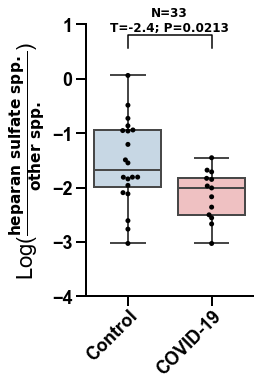

In [77]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

pal_ = {'Control':'#377eb8','COVID-19':'#e41a1c'}
label_ = 'Log($\\frac{\mathrm{heparan\,\,sulfate\,\,spp.}}{\mathrm{other\,\,spp.}}$)'

fig, ax = plt.subplots(1,1, figsize=(3,5))

y_ = 'log_ratio'
lrdf_plot = lrdf.dropna(subset=['log_ratio',
                                'health_status'])

sns.swarmplot(y=y_, x='health_status', 
              data=lrdf_plot, 
              order=['Control'
                     ,'COVID-19'],
              color='black',
              s=5,
              ax=ax)
sns.boxplot(y=y_, x='health_status', 
              data=lrdf_plot,
              order=['Control','COVID-19'],
              palette=pal_,
             ax=ax, linewidth=2)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))


ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.tick_params(axis='y', colors='black', width=2, length=10)
ax.tick_params(axis='x', colors='black', width=2, length=10)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_color("black")
    tick.set_fontsize(18)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(18)
ax.set_ylim(-4, 1)

ax.set_ylabel(label_,
              fontsize=22,
              family = 'arial',
              weight='normal',
              color='black')
ax.set_xlabel('',
              fontsize=22,
              family = 'arial',
              weight='normal',
              color='black')


max_ = []
vals_ = [v[y_].dropna().values for k,v in lrdf_plot.groupby('health_status')]
stat_, p_ = ttest_ind(vals_[0], vals_[1])
x1, x2 = 0, 1
y, h, col = lrdf_plot[y_].max() + 0.5, .25, 'k'
ax.plot([x1, x1, x2, x2],
         [y, y+h, y+h, y],
         lw=1.5, c=col)
if 'e' in str(p_):
    p_ = str(p_)
    p_ = p_[:3] + p_[p_.index('e'):]
    p_ = "N=%i\nT=%.1f; P=%s" % (lrdf_plot.shape[0],stat_,p_)
else:
    p_ = "N=%i\nT=%.1f; P=%.4f" % (lrdf_plot.shape[0],stat_,p_)
ax.text((x1+x2)*.5, y+h,
         p_, ha='center',fontsize=12,
         va='bottom', color=col)

plt.savefig('../results/figures/Fig1A.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()


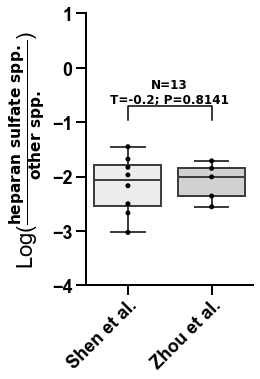

In [78]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

pal_ = {'Control':'#377eb8','COVID-19':'#e41a1c'}
label_ = 'Log($\\frac{\mathrm{heparan\,\,sulfate\,\,spp.}}{\mathrm{other\,\,spp.}}$)'

fig, ax = plt.subplots(1,1, figsize=(3,5))

y_ = 'log_ratio'
lrdf_plot = lrdf.dropna(subset=['log_ratio','health_status'])
lrdf_plot['study'] = lrdf_plot.study.replace({'PRJCA002202':'Shen et al.',
                                              'PRJNA605983':'Zhou et al.'})
lrdf_plot = lrdf_plot[lrdf_plot.health_status == 'COVID-19']
    
sns.swarmplot(y=y_, x='study', 
              data=lrdf_plot, 
              color='black',
              s=5,
              ax=ax)
sns.boxplot(y=y_, x='study', 
              data=lrdf_plot,
              palette='Greys',
             ax=ax, linewidth=2)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))


ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.tick_params(axis='y', colors='black', width=2, length=10)
ax.tick_params(axis='x', colors='black', width=2, length=10)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_color("black")
    tick.set_fontsize(18)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(18)
ax.set_ylim(-4, 1)

ax.set_ylabel(label_,
              fontsize=22,
              family = 'arial',
              weight='normal',
              color='black')
ax.set_xlabel('',
              fontsize=22,
              family = 'arial',
              weight='normal',
              color='black')


max_ = []
vals_ = [v[y_].dropna().values for k,v in lrdf_plot.groupby('study')]
stat_, p_ = ttest_ind(vals_[0], vals_[1])
x1, x2 = 0, 1
y, h, col = lrdf_plot[y_].max() + 0.5, .25, 'k'
ax.plot([x1, x1, x2, x2],
         [y, y+h, y+h, y],
         lw=1.5, c=col)
if 'e' in str(p_):
    p_ = str(p_)
    p_ = p_[:3] + p_[p_.index('e'):]
    p_ = "N=%i\nT=%.1f; P=%s" % (lrdf_plot.shape[0],stat_,p_)
else:
    p_ = "N=%i\nT=%.1f; P=%.4f" % (lrdf_plot.shape[0],stat_,p_)
ax.text((x1+x2)*.5, y+h,
         p_, ha='center',fontsize=12,
         va='bottom', color=col)

plt.savefig('../results/figures/FigS1A.pdf' ,
            dpi=1000, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')

plt.show()

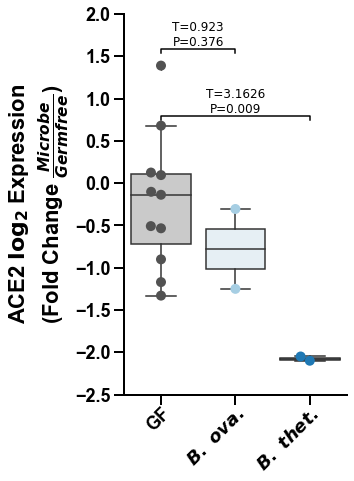

In [81]:
plt.rcParams['xtick.labelsize'] = 18
plt.rcParams['ytick.labelsize'] = 18
plt.rcParams['axes.linewidth'] = 2
plt.rcParams["font.weight"] = "bold"
plt.rcParams["axes.labelweight"] = "bold"
plt.rcParams['xtick.major.pad'] = '.1'

pal_ = {'GF':'#525252',
        '$B.\,\,thet.$':'#1f78b4',
        '$B.\,\,ova.$':'#a6cee3'}

cellsupp = pd.read_excel('/Users/cmartino/Downloads/mmc3.xls', sheet_name='Table S3-colon')

cellsupp = cellsupp[cellsupp.GeneSymbol == 'Ace2']
cols = [x for x in cellsupp.columns if 'Bthet' == x.split('.')[0]] +\
       [x for x in cellsupp.columns if 'Bovat' == x.split('.')[0]] + \
       [x for x in cellsupp.columns if 'Germfree' in x.split('.')[0]]
cellsupp = cellsupp[cols]
cellsupp.index = ['ACE2']
cellsupp = cellsupp.T
cellsupp['type'] = [x.split('.')[0] for x in cellsupp.index]
cellsupp['type'] = cellsupp['type'].replace({'Bthet':'$B.\,\,thet.$',
                                             'Bovat':'$B.\,\,ova.$',
                                             'Germfree':'GF'})


fig, ax = plt.subplots(1,1, figsize=(4,7))


sns.swarmplot(y='ACE2', x='type', 
              order=['GF','$B.\,\,ova.$','$B.\,\,thet.$'],
              palette=pal_,
              data=cellsupp, s=10,
              ax=ax)
sns.boxplot(y='ACE2', x='type',
              order=['GF','$B.\,\,ova.$','$B.\,\,thet.$'],
              palette=pal_,
              data=cellsupp,
             ax=ax)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))


ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('black')
ax.tick_params(axis='y', colors='black', width=2, length=10)
ax.tick_params(axis='x', colors='black', width=2, length=10)
ax.set_xticklabels(ax.get_xticklabels(),
                   rotation=45,
                   horizontalalignment='right',
                   rotation_mode="anchor")
for tick in ax.get_xticklabels():
    tick.set_fontproperties('arial')
    tick.set_ha("right")
    tick.set_color("black")
    tick.set_fontsize(18)
for tick in ax.get_yticklabels():
    tick.set_fontproperties('arial')
    tick.set_color("black")
    tick.set_fontsize(18)


max_ = []
vals_ = {k:v['ACE2'].dropna().values for k,v in cellsupp.groupby('type')}
stat_, p_ = ttest_ind(vals_['GF'], vals_['$B.\,\,ova.$'])
x1, x2 = 0, 1
y, h, col = cellsupp['ACE2'].max() + 0.15, .05, 'k'
ax.plot([x1, x1, x2, x2],
         [y, y+h, y+h, y],
         lw=1.5, c=col)
if 'e' in str(p_):
    p_ = str(p_)
    p_ = p_[:3] + p_[p_.index('e'):]
    p_ = "T=%.3f\nP=%s" % (stat_,p_)
else:
    p_ = "T=%.3f\nP=%.3f" % (stat_,p_)
ax.text((x1+x2)*.5, y+h,
         p_, ha='center',fontsize=12,
        weight='normal',
         va='bottom', color=col)


max_ = []
vals_ = {k:v['ACE2'].dropna().values for k,v in cellsupp.groupby('type')}
stat_, p_ = ttest_ind(vals_['GF'], vals_['$B.\,\,thet.$'])
x1, x2 = 0, 2
y, h, col = vals_['$B.\,\,thet.$'].max() + 2.8, .05, 'k'
ax.plot([x1, x1, x2, x2],
         [y, y+h, y+h, y],
         lw=1.5, c=col)
if 'e' in str(p_):
    p_ = str(p_)
    p_ = p_[:3] + p_[p_.index('e'):]
    p_ = "T=%.4f\nP=%s" % (stat_,p_)
else:
    p_ = "T=%.4f\nP=%.3f" % (stat_,p_)
ax.text((x1+x2)*.5, y+h,
         p_, ha='center',fontsize=12,
        weight='normal',
         va='bottom', color=col)

ax.set_ylabel('ACE2 $\\log_{2}$ Expression\n(Fold Change $\\frac{Microbe}{Germfree}$)',
              fontsize=22,
              family = 'arial',
              color='black')
ax.set_xlabel('',fontsize=22,
              family = 'arial',
              weight='normal',
              color='black')
ax.set_ylim(-2.5, 2)

plt.savefig('../results/figures/FigS3.pdf' ,
            dpi=200, 
            bbox_inches='tight',
            facecolor=fig.get_facecolor(), 
            edgecolor='none')


plt.show()


In [809]:
import numpy as np
import statsmodels.api as sm
import statsmodels.formula.api as smf


meta_stat = lrdf.dropna(subset=['Heparan Sulfate','health_status']).rename({'Heparan Sulfate':'log_ratio'},axis=1)
mod = smf.ols(formula='log_ratio ~  study + health_status',
              data=meta_stat.loc[try_,:])
res = mod.fit()
print(res.summary())

                            OLS Regression Results                            
Dep. Variable:              log_ratio   R-squared:                       0.151
Model:                            OLS   Adj. R-squared:                  0.095
Method:                 Least Squares   F-statistic:                     2.678
Date:                Thu, 30 Jul 2020   Prob (F-statistic):             0.0851
Time:                        13:51:20   Log-Likelihood:                -32.239
No. Observations:                  33   AIC:                             70.48
Df Residuals:                      30   BIC:                             74.97
Df Model:                           2                                         
Covariance Type:            nonrobust                                         
                               coef    std err          t      P>|t|      [0.025      0.975]
--------------------------------------------------------------------------------------------
Intercept               

/Users/cmartino/miniconda3/envs/qiime2-2019.10-songbird/lib/python3.6/site-packages/pandas/core/indexing.py:1418: FutureWarning: 
Passing list-likes to .loc or [] with any missing label will raise
KeyError in the future, you can use .reindex() as an alternative.

See the documentation here:
https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#deprecate-loc-reindex-listlike
  return self._getitem_tuple(key)


In [2]:
tax_map = pd.read_csv('../data/wol-organism-tax.tsv', sep='\t', index_col=0, header=None)
tax_map['sp'] = [' '.join(x.split(' ')[:2]) for x in tax_map[1]]
tax_map['genus'] = [v.split(' ')[0] for v in tax_map.sp]
tax_groutu = {v:k for k, v in zip(tax_map.index, tax_map[1])}
tax_groutu_alt = {' '.join(k.split(' ')[:2]):v for k,v in tax_groutu.items()}
glco_loadings = pd.read_csv('../data/pathway_completeness-capacity.sp.csv', index_col=0)
pathway_microbe_map = {target_:(set(df[df.pathway_completeness_abundance == 1].taxa.dropna()),
                                set(df[df.pathway_completeness_abundance != 1].taxa.dropna()))
                       for target_, df in glco_loadings.groupby('Target') if target_ == 'Heparan Sulfate'}


tax_ = glco_loadings[(glco_loadings.pathway_completeness_abundance ==1) & (glco_loadings.Target =='Heparan Sulfate')].taxa
len(set(tax_.values))

bt1 = load_table('../data/metaanalysis-data/COVID/PRJNA605983-species.biom')
bt2 = load_table('../data/metaanalysis-data/COVID/PRJNA601736-species.biom')
bt3 = load_table('../data/metaanalysis-data/COVID/CRA002475-species.biom')
bt4 = load_table('../data/metaanalysis-data/COVID/CRA002476-species.biom')
bt = bt1.merge(bt2)
bt = bt.merge(bt3)
bt = bt.merge(bt4)
btdf = pd.DataFrame(bt.matrix_data.toarray(),
                    bt.ids('observation'),
                    bt.ids())
#btdf.index = [tax_groutu[x] if x in tax_groutu.keys() else 'drop' for x in btdf.index]
#btdf = btdf.drop('drop')
#btdf.index = [' '.join(ind_.split(' ')[:2]).replace("'","") for ind_ in btdf.index]
btdf = btdf.groupby(btdf.index).sum()
btdf.columns = [x.split('.')[0] if 'SR' in x[:2] else x.split('_')[0]
                for x in btdf.columns]
btdf = btdf.T
#btdf = btdf.groupby(btdf.index).sum()
btdf = btdf.loc[~btdf.index.duplicated(keep='first')]
btdf = btdf.T.drop('Escherichia coli')
btdf.shape

tax_map = pd.read_csv('../data/wol-organism-tax.tsv', sep='\t', index_col=0, header=None)
tax_map['sp'] = [' '.join(x.split(' ')[:2]) for x in tax_map[1]]
tax_map['genus'] = [v.split(' ')[0] for v in tax_map.sp]
#tax_map


# merge the tables for each file
all_hk = glob.glob('../data/mt-functional-covid/count-tables-mt-covid-kh/*')
all_hk = [pd.read_csv(t_,
                          sep='\s+',
                          header=None,
                          index_col=1).rename({0:t_.split('/')[-1][:-4]},
                                              axis=1) 
              for t_ in all_hk if os.stat(t_).st_size != 0]
table_hk = pd.concat(all_hk, axis=1, sort=False).fillna(0)
# split
hks = (table_hk.astype(bool).sum(1)/table_hk.shape[1]).sort_values().index[::-1][:]
table_hk = table_hk.loc[hks ,:]
table_hk = table_hk.sum(0).reindex(btdf.columns).fillna(0)
btdf.loc['housekeep',:] = table_hk


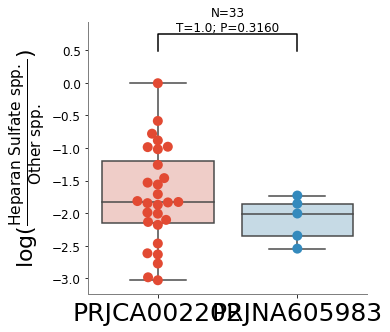

In [811]:
plt.rcParams['xtick.labelsize'] = 25
plt.rcParams['ytick.labelsize'] = 12

label_ = '$\\log(\\frac{\mathrm{Heparan\,\,Sulfate\,\,spp.}}{\mathrm{Other\,\,spp.}})$'
pal_ = {'Control':'#377eb8','COVID':'#e41a1c'}

fig, ax = plt.subplots(1,1, figsize=(5,5))

y_ = 'log_ratio'
lrdf_plot = lrdf.dropna(subset=['Heparan Sulfate','health_status']).rename({'Heparan Sulfate':'log_ratio'},axis=1)
lrdf_plot['health_status'] = lrdf_plot.health_status.replace({'covid':'COVID',
                                                              'healthy':'Control'})
#lrdf_plot = lrdf_plot[lrdf_plot['health_status'] == 'COVID']

sns.swarmplot(y=y_, x='study', 
              data=lrdf_plot, s=10,
              ax=ax)
sns.boxplot(y=y_, x='study', 
              data=lrdf_plot,
             ax=ax)
for patch in ax.artists:
    r, g, b, a = patch.get_facecolor()
    patch.set_facecolor((r, g, b, .3))

ax.set_facecolor('white')
ax.set_axisbelow(True)
ax.spines['right'].set_visible(False)
ax.spines['left'].set_visible(True)
ax.spines['bottom'].set_visible(True)
ax.spines['top'].set_visible(False)
for child in ax.get_children():
    if isinstance(child, matplotlib.spines.Spine):
        child.set_color('grey')
ax.tick_params(axis='y', colors='black')
ax.tick_params(axis='x', colors='black')
ax.set_xlabel('')

ax.set_ylabel(label_, fontsize=22, color='black')
ax.set_xlabel('',fontsize=32, color='black')

max_ = []
vals_ = [v[y_].dropna().values for k,v in lrdf_plot.groupby('study')]
stat_, p_ = ttest_ind(vals_[0], vals_[1])
x1, x2 = 0, 1
y, h, col = lrdf_plot[y_].max() + 0.5, .25, 'k'
ax.plot([x1, x1, x2, x2],
         [y, y+h, y+h, y],
         lw=1.5, c=col)
if 'e' in str(p_):
    p_ = str(p_)
    p_ = p_[:3] + p_[p_.index('e'):]
    p_ = "N=%i\nT=%.1f; P=%s" % (lrdf_plot.shape[0],stat_,p_)
else:
    p_ = "N=%i\nT=%.1f; P=%.4f" % (lrdf_plot.shape[0],stat_,p_)
ax.text((x1+x2)*.5, y+h,
         p_, ha='center',fontsize=12,
         va='bottom', color=col)

#plt.savefig('../results/figures/fig3/balf-covid-hep.png' ,
#            dpi=1000, 
#            bbox_inches='tight',
#            facecolor=fig.get_facecolor(), 
#            edgecolor='none')

plt.show()

In [19]:
cellsupp.to_csv('../data/ACE2-GF.csv')

In [22]:
lrdf_plot[lrdf_plot.health_status == 'Control'].study.value_counts()

PRJCA002202    20
Name: study, dtype: int64

In [26]:
lrdf_plot.age.max()

61.0

In [27]:
21-61 years

SyntaxError: invalid syntax (<ipython-input-27-68e98be2518d>, line 1)

In [ ]:
n_ = ['Bacteroides thetaiotaomicron', 'Bacteroides thetaiotaomicron', 'Bacteroides ovatus']
d_ = list(set(btdf_filt.index) - set(n_))
meta["Bacteroides"] = lratio(btdf_filt, n_, d_)

In [14]:
cellsupp = pd.read_excel('/Users/cmartino/Downloads/mmc3.xls', sheet_name='Table S3-colon')

cellsupp = cellsupp[cellsupp.GeneSymbol == 'Ace2']
cols = [x for x in cellsupp.columns if 'Bthet' == x.split('.')[0]] +\
       [x for x in cellsupp.columns if 'Bovat' == x.split('.')[0]] + \
       [x for x in cellsupp.columns if 'Pdist' == x.split('.')[0]] + \
       [x for x in cellsupp.columns if 'Ssapr' == x.split('.')[0]] + \
       [x for x in cellsupp.columns if 'Germfree' in x.split('.')[0]]
cellsupp = cellsupp[cols]
cellsupp.index = ['ACE2']
cellsupp = cellsupp.T
cellsupp['type'] = [x.split('.')[0] for x in cellsupp.index]

fig, ax = plt.subplots(1,1, figsize=(8,5))


sns.swarmplot(y='ACE2', x='type', 

              data=cellsupp, s=10,
              ax=ax)
sns.boxplot(y='ACE2', x='type',

              data=cellsupp,
             ax=ax)

plt.show()

ImportError: Missing optional dependency 'xlrd'. Install xlrd >= 1.0.0 for Excel support Use pip or conda to install xlrd.

In [46]:
# model
from scipy import interp
from sklearn import svm, datasets
from sklearn.metrics import roc_curve, auc
from sklearn.model_selection import KFold, StratifiedKFold, RepeatedStratifiedKFold, StratifiedShuffleSplit
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler

def RF_ROC(Xdf, ydf, ax, cmean='black', label="Mean ROC"):

    # subset
    X = Xdf.values
    #sc = StandardScaler()
    #X = sc.fit_transform(X)

    le = preprocessing.LabelEncoder()
    y = le.fit_transform(ydf.values)
    n_samples, n_features = X.shape
    # set state
    random_state = np.random.RandomState(0)
    # Run classifier with cross-validation and plot ROC curves
    cv = RepeatedStratifiedKFold(n_splits=5,
                                 n_repeats=4,
                                 random_state=42)
    #cv = KFold(n_splits=10)
    #cv = StratifiedShuffleSplit()
    classifier = RandomForestClassifier(random_state=42,
                                        n_estimators=500)
    #classifier = KNeighborsClassifier()
    # build list too fill
    tprs = []
    aucs = []
    mean_fpr = np.linspace(0, 1, n_samples)
    # run CV
    i = 0
    for train, test in cv.split(X, y):
        probas_ = classifier.fit(X[train], y[train]).predict_proba(X[test])
        # Compute ROC curve and area the curve
        fpr, tpr, thresholds = roc_curve(y[test], probas_[:, 1])
        tprs.append(interp(mean_fpr, fpr, tpr))
        tprs[-1][0] = 0.0
        roc_auc = auc(fpr, tpr)
        aucs.append(roc_auc)
        #plt.plot(fpr, tpr, lw=1., c=cmean, alpha=0.3)

        i += 1
    ax.plot([0, 1], [0, 1], linestyle='--', lw=2, color='gray',
             label='Chance', alpha=.5)

    mean_tpr = np.mean(tprs, axis=0)
    mean_tpr[-1] = 1.0
    mean_auc = auc(mean_fpr, mean_tpr)
    std_auc = np.std(aucs)
    ax.plot(mean_fpr, mean_tpr, color=cmean,
             label=r'%s %0.2f $\pm$ %0.2f' % (label, mean_auc, std_auc),
             lw=2, alpha=.8)
    #label=r'%s (AUC = %0.2f $\pm$ %0.2f)' % (label, mean_auc, std_auc),
    std_tpr = np.std(tprs, axis=0)
    tprs_upper = np.minimum(mean_tpr + std_tpr, 1)
    tprs_lower = np.maximum(mean_tpr - std_tpr, 0)
    ax.fill_between(mean_fpr, tprs_lower, tprs_upper, color=cmean, alpha=.2,
                     label=r'$\pm$ 1 std. dev.')

    ax.set_xlim([-0.05, 1.05])
    ax.set_ylim([-0.05, 1.05])
    ax.set_xlabel('False Positive Rate',
                  fontsize=22, color='black')
    ax.set_ylabel('True Positive Rate',
                  fontsize=22, color='black')
    #plt.title('Receiver operating characteristic example')
    #plt.legend(loc="lower right")
    ax.set_facecolor('white')
    ax.set_axisbelow(True)
    ax.spines['right'].set_visible(False)
    ax.spines['left'].set_visible(True)
    ax.spines['bottom'].set_visible(True)
    ax.spines['top'].set_visible(False)
    ax.spines['bottom'].set_bounds(0, 1)
    ax.spines['left'].set_bounds(0, 1)
    for child in ax.get_children():
        if isinstance(child, matplotlib.spines.Spine):
            child.set_color('grey')
            
    return ax, classifier

/Users/cmartino/miniconda3/envs/qiime2-2019.10-mmvec/lib/python3.6/site-packages/ipykernel_launcher.py:13: FutureWarning: Sorting because non-concatenation axis is not aligned. A future version
of pandas will change to not sort by default.

To accept the future behavior, pass 'sort=False'.

To retain the current behavior and silence the warning, pass 'sort=True'.

  del sys.path[0]
/Users/cmartino/miniconda3/envs/qiime2-2019.10-mmvec/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Users/cmartino/miniconda3/envs/qiime2-2019.10-mmvec/lib/python3.6/site-packages/sklearn/preprocessing/label.py:235: DataConversionWarning: A column-vector y was passed when a 1d array was expected. Please change the shape of y to (n_samples, ), for example using ravel().
  y = column_or_1d(y, warn=True)
/Us

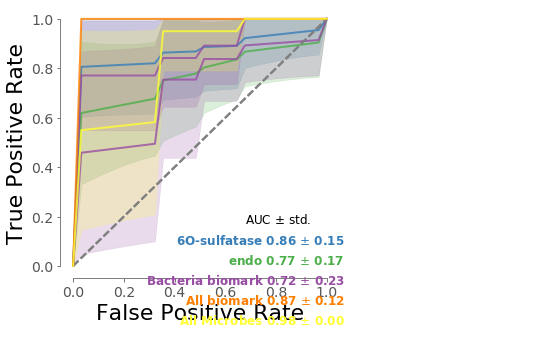

In [48]:

plt.style.use('ggplot')
#paper_rc = {'lines.linewidth': 2, 
#            'lines.markersize': 5}                  
#sns.set_context("paper", rc = paper_rc)   
plt.rcParams['xtick.labelsize'] = 14
plt.rcParams['ytick.labelsize'] = 14


fig, ax = plt.subplots(1,1,figsize=(5,5))

col_learn = 'health_status'
learndf = pd.concat([pd.read_csv('../data/learn-gene.csv',index_col=0),
                     lrdf_plot[['Heparan Sulfate']]], axis=1).dropna()

# run for whole table
Xdf = learndf[['6O-sulfatase']]
ydf = learndf[[col_learn]]
ax, mclass = RF_ROC(Xdf, ydf, ax, cmean='#377eb8',
            label='6O-sulfatase')


Xdf = learndf[['endo']]
ydf = learndf[[col_learn]]
ax, mclass = RF_ROC(Xdf, ydf, ax, cmean='#4daf4a',
            label='endo')

Xdf = learndf[['Heparan Sulfate']]
ydf = learndf[[col_learn]]
ax, mclass = RF_ROC(Xdf, ydf, ax, cmean='#984ea3',
            label='Bacteria biomark')

Xdf = learndf[['Heparan Sulfate','6O-sulfatase','endo']]
ydf = learndf[[col_learn]]
ax, mclass = RF_ROC(Xdf, ydf, ax, cmean='#984ea3',
            label='All biomark')

allmicro = pd.concat([btdf.T.reindex(learndf.index).iloc[:,:-1], learndf[['health_status']]], axis=1)
Xdf = allmicro.iloc[:,:-1]
ydf = allmicro[[col_learn]]
ax, mclass = RF_ROC(Xdf, ydf, ax, cmean='#ff7f00',
            label='All Microbes')

allmicro = pd.concat([btdf.T.reindex(learndf.index).iloc[:,:-1], learndf[['health_status']]], axis=1)
Xdf = allmicro[['Bacteroides thetaiotaomicron', 'Bacteroides ovatus','Ochrobactrum anthropi']]
ydf = allmicro[[col_learn]]
ax, mclass = RF_ROC(Xdf, ydf, ax, cmean='#ffff33',
            label='Bacteroides')


# make a legend
handles, labels = ax.get_legend_handles_labels()
labels = list(labels)[1:2] + list(labels)[3:4] + list(labels)[5:6]  + list(labels)[7:8]   + list(labels)[9:10]
handles = list(handles)[1:2] + list(handles)[3:4]  + list(handles)[5:6] + list(handles)[7:8]   + list(handles)[9:10]
legend = ax.legend(handles, labels, loc=2, 
                         bbox_to_anchor=(0.98, .28),
                         prop={'size':12,
                               'weight':'bold'},
                         handlelength=0, handletextpad=0,
                         fancybox=True, framealpha=0.0, 
                         ncol=1, markerscale=3,
                         facecolor="white",
                         title="AUC $\pm$ std.")
legend.get_title().set_fontsize('12')
legend.get_title().set_ha('right')
legend.get_title().set_position((-100, 0.2))
for item in legend.legendHandles:
    item.set_visible(False)
for text, c in zip(legend.get_texts(),
                   ['#377eb8', '#4daf4a', '#984ea3', '#ff7f00', '#ffff33']):
    text.set_color(c)
    text.set_alpha(1.0)
    text.set_ha('right')
# set the backrounf to be transparent
fig.patch.set_facecolor('white')
fig.patch.set_alpha(0.0)

# save the figure to file
#plt.savefig('results/AUC-Curves.pdf',
#            dpi=600, 
#            bbox_inches='tight',
#            edgecolor='none')

plt.show()


In [12]:
lrdf_plot[['Heparan Sulfate','health_status']].rename({'Heparan Sulfate':'log_ratio'},axis=1)

,log_ratio,health_status
SRS6151290,-3.418771,COVID
SRS6151291,-2.570490,COVID
SRS6151292,-2.048272,COVID
SRS6151293,-2.667315,COVID
SRS6151294,-2.365005,COVID
SRS6007143,-1.161991,COVID
SRS6007144,-2.921830,COVID
CRR125934,-3.017862,COVID
CRR125935,-1.203914,COVID
CRR125936,-0.812988,COVID


In [11]:
Proteus mirabilis

,value,Target,total_counts,taxa,log_counts,CAZy.ID,EC_abundance_sum,EC_abundance_mean,pathway_completeness_abundance,threshold_p,threshold_p_adj,threshold,gene_score,EC_score_max,EC_score_mean,pathway_capacity
1044,3.2.1.18,O-glycan,66446,Proteus mirabilis,11.10416,GH33,11.10416,11.10416,1,0.526531,0.526531,7.883772,4.394986,4.394986,4.394986,4.15377
2754,3.2.1.18,N-glycan,66446,Proteus mirabilis,11.10416,GH33,11.10416,11.10416,1,0.526531,0.526531,7.883772,4.394986,4.394986,4.394986,4.15377
6968,3.2.1.23,Keratan Sulfate,66446,Proteus mirabilis,11.10416,GH3,11.10416,11.10416,1,0.667068,0.667068,8.574319,4.153770,4.153770,4.153770,4.15377
11925,3.2.1.23,N-glycan,66446,Proteus mirabilis,11.10416,GH3,11.10416,11.10416,1,0.667068,0.667068,8.574319,4.153770,4.153770,4.153770,4.15377
16882,3.2.1.23,O-glycan,66446,Proteus mirabilis,11.10416,GH3,11.10416,11.10416,1,0.667068,0.667068,8.574319,4.153770,4.153770,4.153770,4.15377
31798,3.2.1.45,O-glycan,66446,Proteus mirabilis,11.10416,GH3,11.10416,11.10416,1,0.667068,0.667068,8.574319,4.153770,4.153770,4.153770,4.15377
33868,3.2.1.52,Hyaluronan,66446,Proteus mirabilis,11.10416,GH3,11.10416,11.10416,1,0.667068,0.667068,8.574319,4.153770,4.153770,4.153770,4.15377
37833,3.2.1.52,Keratan Sulfate,66446,Proteus mirabilis,11.10416,GH3,11.10416,11.10416,1,0.667068,0.667068,8.574319,4.153770,4.153770,4.153770,4.15377
41798,3.2.1.52,N-glycan,66446,Proteus mirabilis,11.10416,GH3,11.10416,11.10416,1,0.667068,0.667068,8.574319,4.153770,4.153770,4.153770,4.15377
45763,3.2.1.52,O-glycan,66446,Proteus mirabilis,11.10416,GH3,11.10416,11.10416,1,0.667068,0.667068,8.574319,4.153770,4.153770,4.153770,4.15377


,Heparan Sulfate,study,sampleid,sample_accession,run_accession,experiment_accession,r1,r2,age,gender,covid_status,health_status,read_counts
SRS6151290,-3.418771,PRJNA605983,WIV07,SRS6151290,SRR11092064,SRX7730879,SRS6151290.SRR11092064_R1.fastq.gz,SRS6151290.SRR11092064_R2.fastq.gz,56.0,male,True,COVID,17714488.0
SRS6151291,-2.570490,PRJNA605983,WIV02,SRS6151291,SRR11092058,SRX7730885,SRS6151291.SRR11092058_R1.fastq.gz,SRS6151291.SRR11092058_R2.fastq.gz,32.0,male,True,COVID,4533.0
SRS6151292,-2.048272,PRJNA605983,WIV04,SRS6151292,SRR11092057,SRX7730886,SRS6151292.SRR11092057_R1.fastq.gz,SRS6151292.SRR11092057_R2.fastq.gz,49.0,female,True,COVID,5132.0
SRS6151293,-2.667315,PRJNA605983,WIV05,SRS6151293,SRR11092061,SRX7730882,SRS6151293.SRR11092061_R1.fastq.gz,SRS6151293.SRR11092061_R2.fastq.gz,52.0,female,True,COVID,734906.0
SRS6151294,-2.365005,PRJNA605983,WIV06,SRS6151294,SRR11092056,SRX7730887,SRS6151294.SRR11092056_R1.fastq.gz,SRS6151294.SRR11092056_R2.fastq.gz,40.0,male,True,COVID,4542.0
SRS6007143,-1.161991,PRJNA601736,wuhan1,SRS6007143,SRR10903402,SRX7571570,SRS6007143.SRR10903402_R1.fastq.gz,SRS6007143.SRR10903402_R2.fastq.gz,39.0,male,True,COVID,18387.0
SRS6007144,-2.921830,PRJNA601736,wuhan2,SRS6007144,SRR10903401,SRX7571571,SRS6007144.SRR10903401_R1.fastq.gz,SRS6007144.SRR10903401_R2.fastq.gz,21.0,female,True,COVID,3895.0
CRR125934,-3.017862,PRJCA002202,nCov8,SAMC134556,CRX101772,CRR125934,CRR125934_r1.fq.gz,CRR125934_r2.fq.gz,41.0,male,True,COVID,825750.0
CRR125935,-1.203914,PRJCA002202,nCov7,SAMC134555,CRX101773,CRR125935,CRR125935_r1.fq.gz,CRR125935_r2.fq.gz,53.0,female,True,COVID,2028060.0
CRR125936,-0.812988,PRJCA002202,nCov6,SAMC134554,CRX101774,CRR125936,CRR125936_r1.fq.gz,CRR125936_r2.fq.gz,56.0,male,True,COVID,60073.0


In [149]:
lrdf_plot.health_status.value_counts()


COVID      23
Control    20
Name: health_status, dtype: int64

In [409]:
btdf_filt.astype(bool).sum(1) / btdf_filt.shape[1]

['Prevotella salivae','Prevotella histicola','']


['Prevotella salivae', 'Prevotella histicola', '']

In [410]:
usobacterium and Veillonell

NameError: name 'usobacterium' is not defined

In [427]:
d_

{'Abiotrophia defectiva',
 'Actinomyces odontolyticus',
 'Asanoa ferruginea',
 'Bavariicoccus seileri',
 'Brucella suis',
 'Campylobacter mucosalis',
 'Curvibacter lanceolatus',
 'Delftia acidovorans',
 'Hydrotalea flava',
 'Kushneria aurantia',
 'Methylobacterium populi',
 'Methylobacterium sp. ARG-1',
 'Methylobacterium sp. Leaf399',
 'Methylobacterium sp. Leaf456',
 'Morococcus cerebrosus',
 'Nitratireductor indicus',
 'Ochrobactrum pseudogrignonense',
 'Ochrobactrum sp. CDB2',
 'Prevotella histicola',
 'Prevotella salivae',
 'Sphingomonas sp. Leaf33',
 'Streptococcus infantis',
 'Streptococcus oralis',
 'Streptococcus parasanguinis',
 'Variovorax paradoxus',
 'Variovorax sp. URHB0020',
 'Veillonella parvula'}

In [16]:
set(lrdf_plot.study)


{'PRJCA002202', 'PRJNA601736', 'PRJNA605983'}

In [ ]:
PRJCA002202, PRJNA601736, PRJNA605983

In [207]:
lrdf.dropna(subset=['r2'])

,Heparan Sulfate,study,sampleid,sample_accession,run_accession,experiment_accession,r1,r2,age,gender,covid_status,health_status,read_counts
SRS6151290,-3.340422,PRJNA605983,WIV07,SRS6151290,SRR11092064,SRX7730879,SRS6151290.SRR11092064_R1.fastq.gz,SRS6151290.SRR11092064_R2.fastq.gz,56.0,male,True,covid,17735782.0
SRS6151291,-2.397406,PRJNA605983,WIV02,SRS6151291,SRR11092058,SRX7730885,SRS6151291.SRR11092058_R1.fastq.gz,SRS6151291.SRR11092058_R2.fastq.gz,32.0,male,True,covid,4389.0
SRS6151292,-1.860094,PRJNA605983,WIV04,SRS6151292,SRR11092057,SRX7730886,SRS6151292.SRR11092057_R1.fastq.gz,SRS6151292.SRR11092057_R2.fastq.gz,49.0,female,True,covid,4750.0
SRS6151293,-2.554163,PRJNA605983,WIV05,SRS6151293,SRR11092061,SRX7730882,SRS6151293.SRR11092061_R1.fastq.gz,SRS6151293.SRR11092061_R2.fastq.gz,52.0,female,True,covid,738349.0
SRS6151294,-1.960596,PRJNA605983,WIV06,SRS6151294,SRR11092056,SRX7730887,SRS6151294.SRR11092056_R1.fastq.gz,SRS6151294.SRR11092056_R2.fastq.gz,40.0,male,True,covid,2989.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...
CRR125993,-1.312090,PRJCA002202,V24,SAMC149804,CRX101831,CRR125993,CRR125993_r1.fq.gz,CRR125993_r2.fq.gz,72.0,male,False,pneumonia,293680.0
CRR125994,-2.248933,PRJCA002202,V25,SAMC149805,CRX101832,CRR125994,CRR125994_r1.fq.gz,CRR125994_r2.fq.gz,NaN,NaN,False,pneumonia,34569.0
CRR125995,-0.240839,PRJCA002202,nc1,SAMC149806,CRX101833,CRR125995,CRR125995_r1.fq.gz,CRR125995_r2.fq.gz,NaN,NaN,NaN,NaN,19494127.0
CRR125996,-0.415862,PRJCA002202,nc2,SAMC149807,CRX101834,CRR125996,CRR125996_r1.fq.gz,CRR125996_r2.fq.gz,NaN,NaN,NaN,NaN,20694872.0
